**<span style="text-decoration:underline;">Vignette ID: </span>** G1.L1.1

**<span style="text-decoration:underline;">Short Name:</span>** Root+birth/death

Member of Vignette Graph: G1-Basic Epi Theory-Intro to Epymorph

---

**<span style="text-decoration:underline;">Description: </span>** In this vignette, we introduce the concept of adding birth/death nodes to an IPM, based on the basic root scenario. We build on the single-node SIR model introduced earlier, and walk through how to effectively account for birth/death, as well as exploring the effects of configuring different birth/death rate parameters.

- G1.L0.1

  <span style="text-decoration:underline;">Outbound (foundation for):</span>

- item

**Uses Model:** SIR, single node

**<span style="text-decoration:underline;">LEARNING OUTCOMES</span>**

    Epymorph features/tech:

- Editing IPM: to add compartments
- Editing IPM: inserting edges (rate equations)
- Editing IPM parameters and iteratively running.
- Editing graphing functions to modify visualizations.

  Epi Domain learning

- How to iteratively explore parameter change effects.
- Cycling Disease dynamics

---

**SCENARIO:**

In many modeling scenarios, it is important to account for changes in host populations over time due to births and deaths. In some cases, losses may be due to fatalities due to pathogen infection; in other scenarios, the organisms being modeled simply have natural life spans or cycles that fall within the modeling timeframe. In either case, we address this issue by adding explicit “birth” and “death” compartments to our model. The exercises in this vignette show you how to do this in epymorph, as well as exploring how birth/death dynamics can affect model behavior.


**EXERCISES: **[here we continue on with specific modeling exercises to do]

1. You will copy the basic SIR model from the epymorph library and alter as described below, to create a new model of SIR with host demography.
2. Adding birth: Add the special compartment called “BIRTH” to your model, by editing the IPM spec file. Then add a new rate equation (edge) connecting the new ‘BIRTH’ compartment to the ‘S’ compartment, using the the rate equation “birth_rate \* N”. This assumes that all hosts can have offspring, and all of those offspring will be susceptible.


In [1]:
from sympy import Max

from epymorph.compartment_model import *


def construct_ipm():
    symbols = create_symbols(
        compartments=[
            compartment('S'),
            compartment('I'),
            compartment('R'),
        ],
        attributes=[
            param('beta', shape=Shapes.TxN),
            param('gamma', shape=Shapes.TxN),
            param('xi', shape=Shapes.TxN),
            param('birth_rate', shape=Shapes.TxN),  # birth rate per day per capita
        ])

    [S, I, R] = symbols.compartment_symbols
    [β, γ, ξ, br] = symbols.attribute_symbols

    N = Max(1, S + I + R)

    return create_model(
        symbols=symbols,
        transitions=[
            # traditional formulation for S,I,R
            edge(S, I, rate=β * S * I / N),
            edge(I, R, rate=γ * I),
            edge(R, S, rate=ξ * R),
            # newborn individuals enter S
            edge(BIRTH, S, rate=br * (S + I + R)),
        ]
    )

    # formulate N so as to avoid dividing by zero;
    # this is safe in this instance because if the denominator is zero,
    # the numerator must also be zero
    N = Max(1, BIRTH + S + I + R)


BSIR_ipm = construct_ipm()

3. Adding death: Now add the special compartment called “DEATH” to your model by editing the IPM file, also adding several edges (from S, I, and R to “DEATH” with a rate of “death_rate\*[State Variable]” to account for some infected individuals naturally dying. It is simplest to assume that birth_rate and death_rate are equivalent.


In [2]:
from sympy import Max

from epymorph.compartment_model import *


def construct_ipm():
    symbols = create_symbols(
        compartments=[
            compartment('S'),
            compartment('I'),
            compartment('R'),
        ],
        attributes=[
            param('beta', shape=Shapes.TxN),
            param('gamma', shape=Shapes.TxN),
            param('xi', shape=Shapes.TxN),
            param('birth_rate', shape=Shapes.TxN),  # birth rate per day per capita
            param('death_rate', shape=Shapes.TxN),  # death rate per day per capita
        ])

    [S, I, R] = symbols.compartment_symbols
    [β, γ, ξ, br, dr] = symbols.attribute_symbols

    N = Max(1, S + I + R)

    return create_model(
        symbols=symbols,
        transitions=[
            # traditional formulation for S,I,R
            edge(S, I, rate=β * S * I / N),
            edge(I, R, rate=γ * I),
            edge(R, S, rate=ξ * R),
            # newborn individuals enter S
            edge(BIRTH, S, rate=br * (S + I + R)),
            # death edges
            edge(S, DEATH, rate=dr * S),
            edge(I, DEATH, rate=dr * I),
            edge(R, DEATH, rate=dr * R),
        ])

    # formulate N so as to avoid dividing by zero;
    # this is safe in this instance because if the denominator is zero,
    # the numerator must also be zero
    N = Max(1, BIRTH + S + I + R + DEATH)


BSIRD_ipm = construct_ipm()

4. Use epymorph’s built-in feature to plot your model diagram (i.e., the box-and-arrow flow diagram of the system of equations).


Below is the box and arrow plot for the BSIRD (Birth and Death added to SIR) IPM.



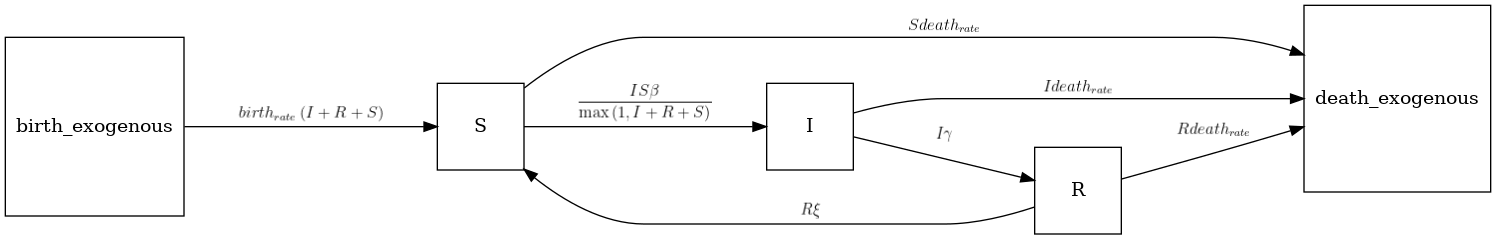

In [52]:
from epymorph import ipm_library, render, render_and_save

ipm = BSIRD_ipm  # ipm_library['sirs']()
print("Below is the box and arrow plot for the BSIRD (Birth and Death added to SIR) IPM.\n")
render(ipm)

5. Choose a single node GEO and null MM. You’ll need a very large population size to see how this model works over the long term. We suggest running the model for at least 50 years. Based on the suggested parameter values, shown below, you should see damped oscillation dynamics.


In [3]:
# import the necessary libraries
from datetime import date
from functools import partial

import numpy as np

from epymorph import *
from epymorph.data import geo_library, mm_library
from epymorph.initializer import single_location

# create the simulation
# pull in the chosen geo, ipm, and movement models
# adjust the parameters for the disease your working with
# try increasing the beta for larger more rapid outbreak first
sim = StandardSimulation(
    ipm=BSIRD_ipm,
    geo=geo_library['single_pop'](),
    mm=mm_library['no'](),
    params={
        'phi': 40.0,
        'beta': 0.4,
        'gamma': 1 / 4,
        'xi': 1 / 90,
        'birth_rate': 0.25 / 365,  # 12.314 persons per thousand, as an approx. daily rate
        'death_rate': 0.2 / 365,  # 8.369 persons per thousand, as an approx. daily rate
    },
    # error with the time frame not being able to go up to 365*50 for 50 years
    time_frame=TimeFrame.of("2015-01-01", 365 * 50),
    initializer=partial(single_location, location=0, seed_size=10_000),
    rng=default_rng(),
)

with sim_messaging(sim):
    out = sim.run()

Running simulation (StandardSimulation):
• 2015-01-01 to 2064-12-19 (18250 days)
• 1 geo nodes
|####################| 100% 
Runtime: 2.588s


In [5]:
out

Output(dim=SimDimensions(tau_step_lengths=[1.0], tau_steps=1, days=18250, ticks=18250, nodes=1, compartments=3, events=7, TNCE=(18250, 1, 3, 7)), geo_labels=['AZ'], compartment_labels=['S', 'I', 'R'], event_labels=['S → I', 'I → R', 'R → S', 'birth_exogenous → S', 'S → death_exogenous', 'I → death_exogenous', 'R → death_exogenous'], initial=array([[90000, 10000,     0]]), prevalence=array([[[ 86488,  10971,   2559]],

       [[ 82831,  11896,   5292]],

       [[ 78903,  12928,   8180]],

       ...,

       [[760521,  20065, 426371]],

       [[760580,  20147, 426387]],

       [[760646,  20318, 426366]]]), incidence=array([[[3532, 2559,    0, ...,   55,    2,    0]],

       [[3689, 2758,   25, ...,   54,    6,    0]],

       [[3992, 2949,   56, ...,   49,   11,    5]],

       ...,

       [[5098, 4943, 4858, ...,  444,   11,  237]],

       [[5044, 4949, 4718, ...,  433,   13,  215]],

       [[5099, 4921, 4720, ...,  423,    7,  222]]]))

6. Run your simulation and plot the dynamics of the Infectious class over time as a single line. Note that you may need to run your model several times in case early burnout occurs.


Running simulation (StandardSimulation):
• 2015-01-01 to 2064-12-19 (18250 days)
• 1 geo nodes
|####################| 100% 
Runtime: 9.349s


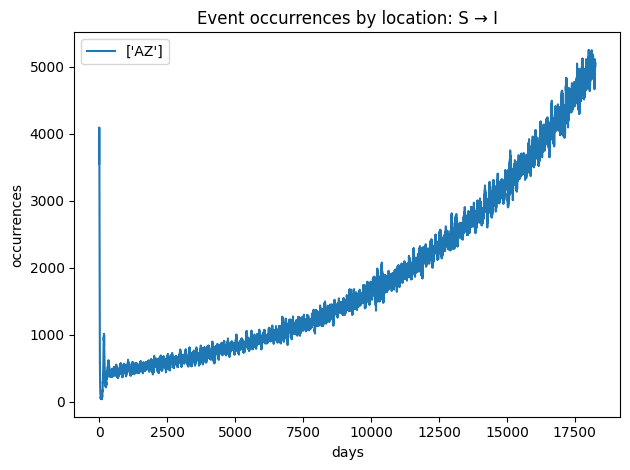

Running simulation (StandardSimulation):
• 2015-01-01 to 2064-12-19 (18250 days)
• 1 geo nodes
|####################| 100% 
Runtime: 10.243s


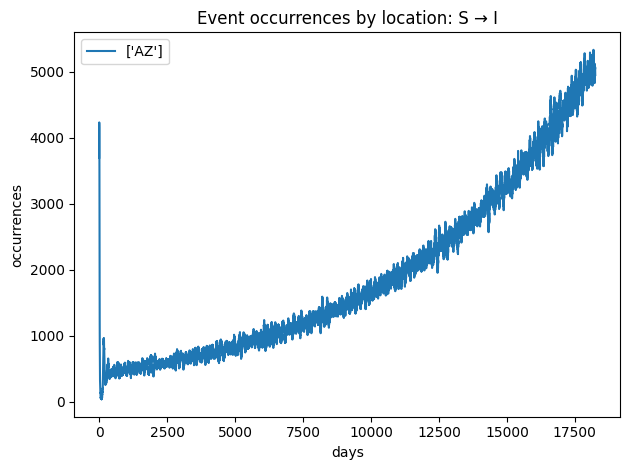

Running simulation (StandardSimulation):
• 2015-01-01 to 2064-12-19 (18250 days)
• 1 geo nodes
|####################| 100% 
Runtime: 9.632s


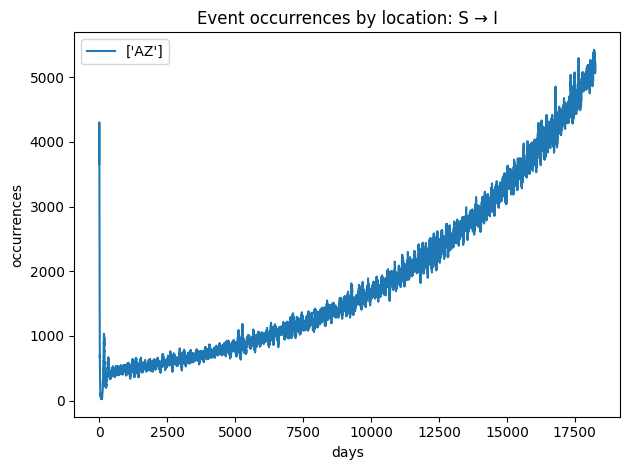

In [22]:
S_TO_I = 0

for num in range(0, 3):
    with sim_messaging(sim):
        output = sim.run()
        # plot S to I transition and
        plot_event(output, event_idx=S_TO_I)

7. [ADVANCED] Basic epi theory shows that this model leads to a stable point equilibrium where the dynamics proceed to this stable point with damped oscillations. Set up an array of initial conditions (i.e., different fractions of the population initially infected), and run your simulation for each initial condition. Plot all of the Infectious over time curves on the same graph to show that even if the model starts with fractions of the population initially infected, the model goes to the same stable point.
